In [238]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

import os
from PIL import Image

import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

## Plan:
- Use a pre-trained model for feature extraction
- Make pre-trained/homemade model for feature processing
- Compute 20*20 asymetric cosine similarity matrix
- Select top 2 images most similar to 'left' image

# 0. Pipeline

In [223]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 10 * 13 + 64 * 10 * 13 * 20, 128)
        self.fc2 = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x1, x2):
        x1 = self.pool(torch.relu(self.conv1(x1)))
        x1 = self.pool(torch.relu(self.conv2(x1)))
        x1 = x1.view(-1, 64 * 10 * 13)
        x2 = [self.pool(torch.relu(self.conv1(x))) for x in x2]
        x2 = [self.pool(torch.relu(self.conv2(x))) for x in x2]
        x2 = [x.view(-1, 64 * 10 * 13) for x in x2]
        x2 = torch.cat(x2, dim=1)
        x = torch.cat((x1, x2), dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [224]:
# Define the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

test cell below

In [288]:
# Define the dataset class
class ImagePairDataset(Dataset):
    def __init__(self, true_pairs_csv, candidate_pairs_csv, left_dir, right_dir, transform=None):
        self.pairs = pd.read_csv(true_pairs_csv)
        self.candidate_pairs = pd.read_csv(candidate_pairs_csv)
        self.left_dir = left_dir
        self.right_dir = right_dir
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        left_name = os.path.join(self.left_dir, self.pairs.iloc[idx, 0] + '.jpg')
        right_names = [os.path.join(self.right_dir, self.candidate_pairs.iloc[idx, i] + '.jpg') for i in range(1, len(self.candidate_pairs.iloc[idx, :]))]
        left_image = np.array(Image.open(left_name))
        right_images = np.array([np.array(Image.open(right_name)) for right_name in right_names])
        label = np.array([1 if self.pairs.iloc[idx, 1] == self.candidate_pairs.iloc[idx, i] else 0 for i in range(1, len(self.candidate_pairs.iloc[idx, :]))])
        # if self.transform:
        #     left_image = self.transform(left_image)
        #     right_images = self.transform(right_images)
        return left_image, right_images, label

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((49, 40)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define the dataset and data loader
dataset = ImagePairDataset('train.csv', 'train_candidates.csv', 'train/left', 'train/all', transform=transform)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

max cos_sim:  0.7556936144828796


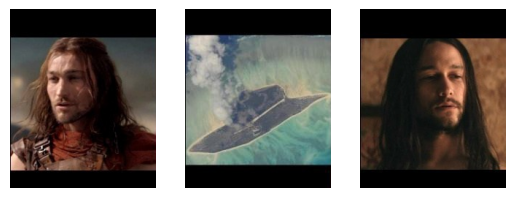

max cos_sim:  0.7304969429969788


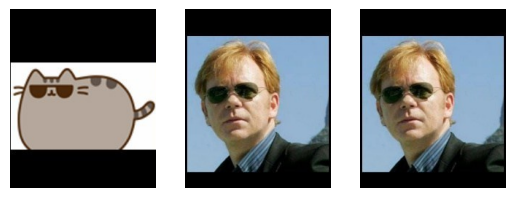

In [330]:
for i, data in enumerate(train_loader):
    if i<2:
        a, b, c = data
        a = a.type(torch.float32)
        b = b.type(torch.float32)
        # calculate cosine similarity
        cos_sim = np.array([F.cosine_similarity(a.reshape(1, -1), d.reshape(1, -1)).item() for d in b[0]])
        print('max cos_sim: ', np.max(cos_sim))
        # Show side by side a and the argmax of cos_sim
        plt.subplot(1, 3, 1)
        plt.imshow(a.squeeze().numpy()/255.)
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(b[0][np.argmax(cos_sim)].squeeze().numpy()/255.)
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(b[0][np.argmax(c)].squeeze().numpy()/255.)
        plt.axis('off')
        plt.show()
    else: 
        break

# 1. Feature Extraction

#### Clip ResNet 50x4

In [ ]:
# !conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git
# !pip install torch

In [96]:
from torchvision.models import resnet50, ResNet50_Weights

# New weights with accuracy 80.858%
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [115]:
from clip import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model, transform = clip.load("RN50x4", device)

cpu
